In [1]:
from emlib import emlib
import logging
import math
emlib.emlog.setLevel(logging.INFO)

In [2]:
def NPZNB_int(t,initial,dtinput,constants):

    P = initial[0]          # phytoplankton
    B = initial[1]             # benthos
    Z = initial[2]             # zooplankton
    DIN = initial[3]           # dissolved inorganic
    DON = initial[4]           # dissolved organic
    ddin = dtinput.Val("ddin") #Concentration by day from WRTDS model 2 columns date and ddin Units are mg/L N
    dtemp = dtinput.Val("TEMP")  #daily temperature of water 
    ddon = dtinput.Val("ddon") #Concentration by day from WRTDS model 2 columns date and ddon mg/l N
    #dtemp = dtinput.Val("dtemp")  #daily temperature of water 
    
    #i = constants.Val("i")      #irradiance
    Pg = constants.Val("Pg")    # max P growth
    Bg = constants.Val("Bg")    # max B growth
    e = constants.Val("e")      # Z ingestion
    Zm = constants.Val("Zm")    # Z mortality
    Pm = constants.Val("Pm")    # P mortality
    Bm = constants.Val("Bm")    # B mortality
    Pe = constants.Val("Pe")    # P excretion
    Be = constants.Val("Be")    # B excretion
    Pr = constants.Val("Pr")    # P recycle
    h = constants.Val("h")      # Z grazing
    s = constants.Val("s")      # sedimentation
    f = constants.Val("f")      # flushing rate
    in_scale = constants.Val("in_scale")      # input scaling rate
    
    # 0.81e0.0631T optimal phytoplankton growth rate to temperature 
    #https://aslopubs.onlinelibrary.wiley.com/doi/abs/10.4319/lo.2008.53.2.0487
    
    
    P_dot = ((Pg * P * DIN) * (0.81 * math.exp(0.0631 * dtemp))) + (Pr * DON * P* (0.81 * math.exp(0.0631 * dtemp))) \
           - (h * P * Z) - (Pm * P * P) - (Pe * P)
    B_dot = (Bg * B)/ (1 + Bg * B) * (DON + DIN) - (Bm * B) - (Be * B * B)
    Z_dot = (h * e) - (h * P * Z) - (Zm * Z *Z )
   
    
    DIN_dot = (ddin * in_scale) + (0.8* (1 - e) * h * P * Z) + (Be * B)+  (Pe * P) \
                - (Pg * P * DIN) - ((Bg * B)/ (1 + Bg * B) * (DIN)) - (f * DIN)
    DON_dot = (ddon * in_scale) + (Bm * B)  +(Pm * P)  + (Zm * Z)  + (0.2 * (1 - e) * h * P * Z) \
             - (Pr * DON * P)  - ((Bg * B)/ (1 + Bg * B) * (DON))  - (s * DON) - (f * DON)
    
    return [P_dot,B_dot,Z_dot,DIN_dot,DON_dot]

In [24]:
NPZUS = emlib.Model(NPZNB_int) #save the model

INFO -1105- New Model(3): NPZNB_int
INFO -1117- No algorithm supplied assuming vode/bfd O12 Nsteps3000 dt1


In [29]:
#nutrients= emlib.TimeSeries(dirname="Data",filename="Guadalupe_input.csv") #loading in input timeseries data ddin and ddon in same file
#nutrients_alltime= emlib.TimeSeries(dirname="Data",filename="Guadalupe_inputall.csv")
nutrients_UT= emlib.TimeSeries(dirname="Data",filename="SABAY-master.csv")
#temperature = emlib.TimeSeries(dirname="Data",filename="GEC-dailytemp.csv")


benthos_observation = emlib.Observation ("B", dirname="Data",filename= "US_MG.csv")  
zoop_observation = emlib.Observation ("Z", dirname="Data",filename= "US_Zoop.csv")  
#chla_observation = emlib.Observation ("P", dirname="Data",filename= "US_Chl_Original.csv")  
chla_observation = emlib.Observation ("P", dirname="Data",filename= "GE-trans.csv")  

NPZUScalibration = emlib.Calibration()  #all of our coefficients
#NPZUScalibration.Add("i",val=0.807403237530, min= 0.01, max= 3.0)#from Turner 2014
NPZUScalibration.Add("Pg",val=2.167839,min= 0.1, max= 3.0)#from Turner 2014
NPZUScalibration.Add("Bg",val=1.18904,min= 0.1, max= 3.0)#from Turner 2014
NPZUScalibration.Add("e",val=0.36560,min= 0.01, max= 1.0)#from Turner 2014
NPZUScalibration.Add("Zm",val=0.812665611,min= 0.01, max= 1.0)#from Turner 2014
NPZUScalibration.Add("Pm",val=0.509776,min= 0.01, max= 1.0)#from Turner 2014
NPZUScalibration.Add("Bm",val=1.0108543,min= 0.01, max= 1.0)#from Turner 2014
NPZUScalibration.Add("Pe",val=0.88884,min= 0.01, max= 1.0)#random number
NPZUScalibration.Add("Be",val=0.894376,min= 0.01, max= 1.0)#random number
NPZUScalibration.Add("Pr",val=1.6583455,min= 0.01, max= 1.0)#random number
NPZUScalibration.Add("h",val=0.3765959,min=0.01,max=1.0)#random moving number
NPZUScalibration.Add("s",val=2.130104872,min= .1, max= 1.0)#from Turner 2014
NPZUScalibration.Add("f",val=0.110332211,min= .1, max= 1.0)#from Turner 2014
NPZUScalibration.Add("in_scale",val=15.5,min= 15.0, max= 25.0)#from Turner 2014
NPZUScalibration.initial=[0.1,0.1,0.1,0.1,0.1]

legend = ["P", "B", "Z", "DIN","DON"]   #our graph legend



INFO -880- New TimeSeries instance: 6
INFO -759- Read file DataUS_MG.csv 110 Observations for value B
INFO -759- Read file DataUS_Zoop.csv 5 Observations for value Z
INFO -759- Read file DataGE-trans.csv 41 Observations for value P
INFO -353- New Calibration instance: 6


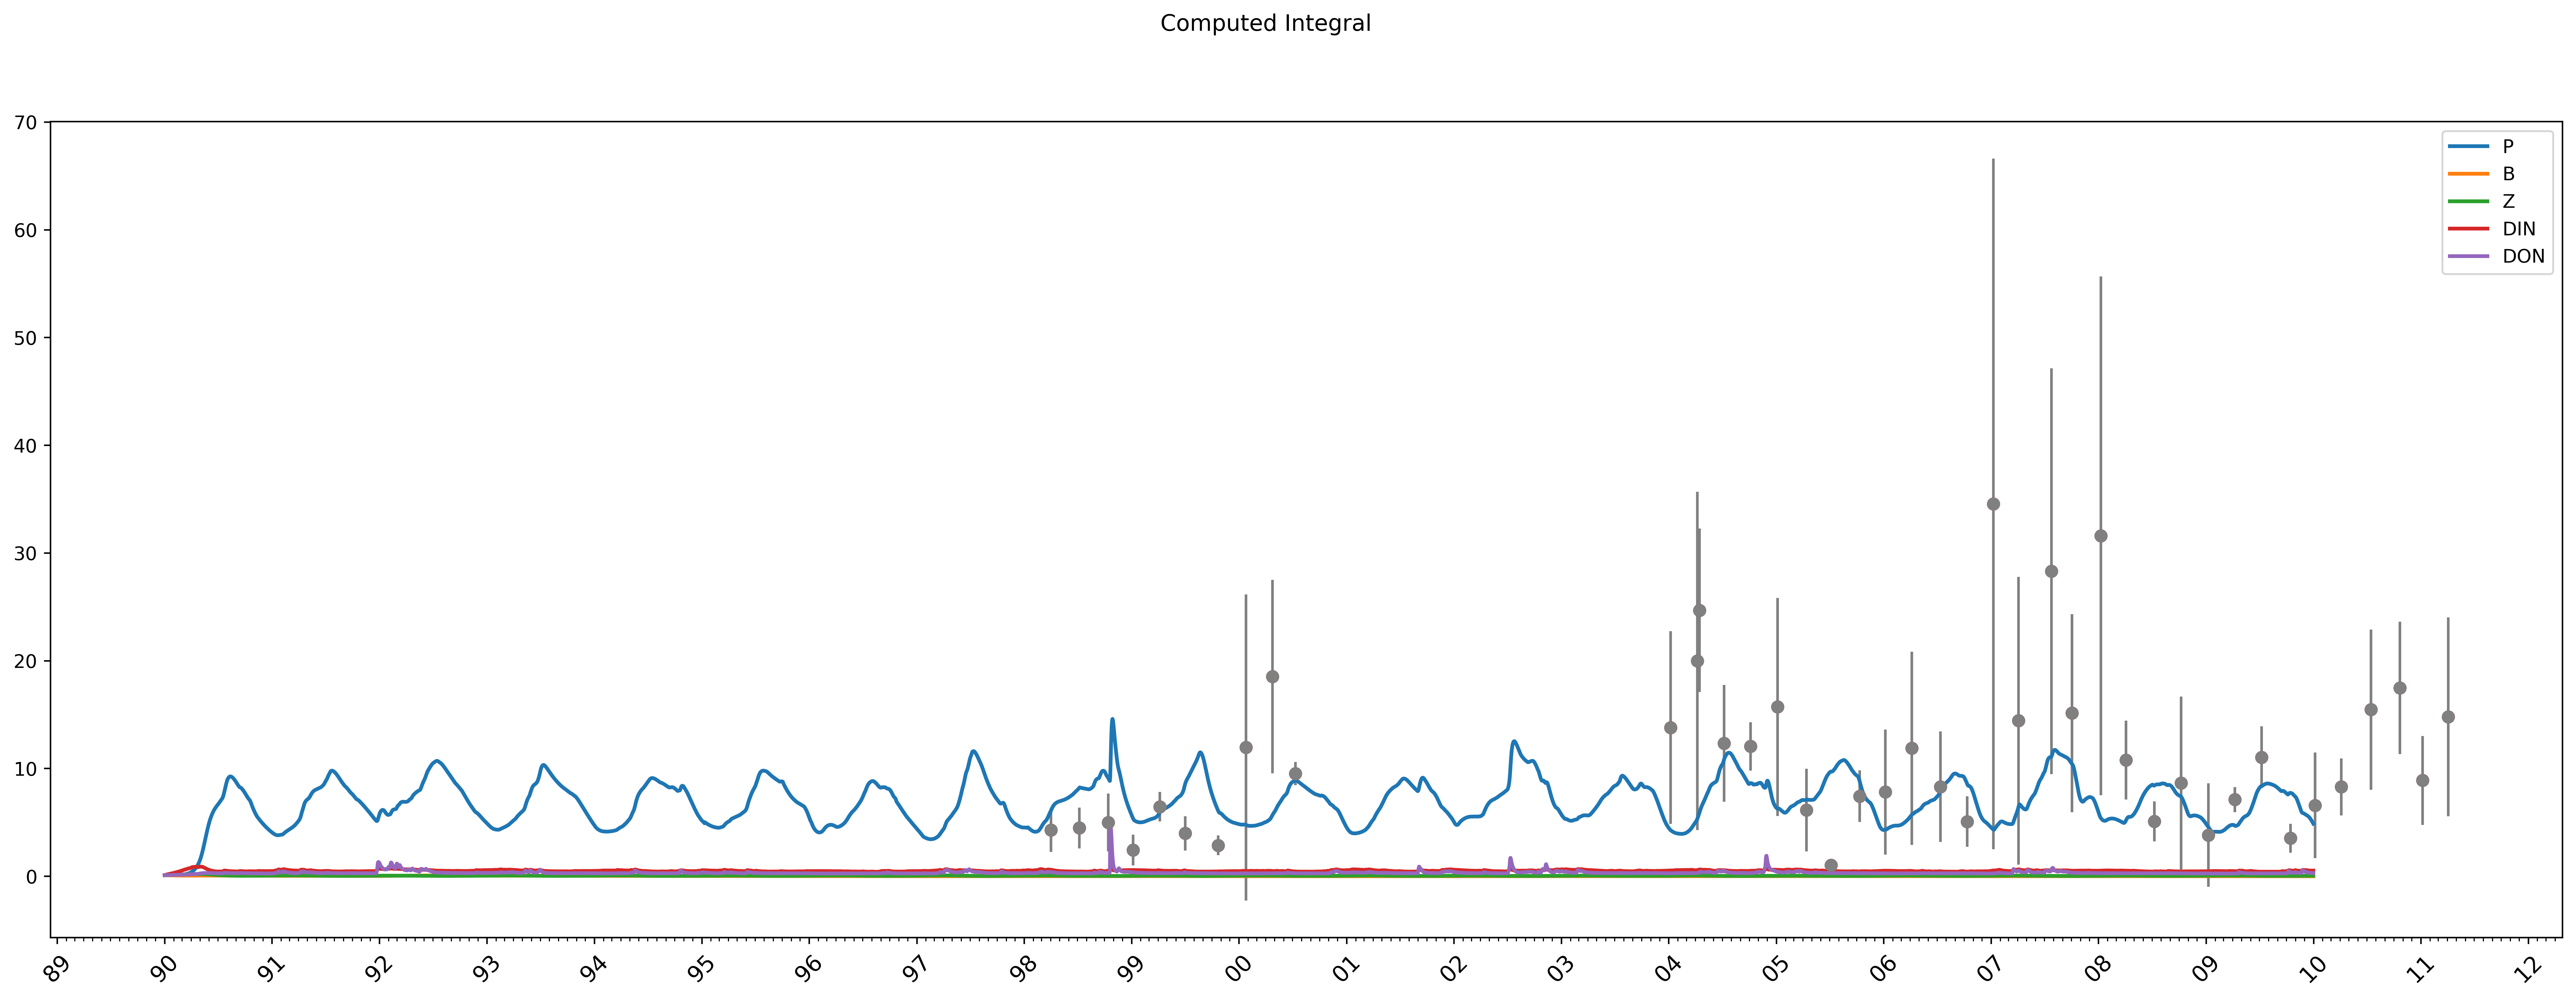

GFMODEL #35 Xtot:4.186 RMSD:45.0 RMSE:9.637 RANGE%54.3 MSER:15.9 WMSE:12.1
Label	Value	Min	Max	ISConst	Desc
Pg 	 2.167839 	 0.01 	 3.0 	 False 	 None
Bg 	 1.18904 	 0.01 	 3.0 	 False 	 None
e 	 0.3656 	 0.01 	 1.0 	 False 	 None
Zm 	 0.812665611 	 0.01 	 3.0 	 False 	 None
Pm 	 0.509776 	 0.01 	 1.0 	 False 	 None
Bm 	 1.0108543 	 0.01 	 1.0 	 False 	 None
Pe 	 0.88884 	 0.01 	 1.0 	 False 	 None
Be 	 0.894376 	 0.01 	 1.0 	 False 	 None
Pr 	 1.6583455 	 0.01 	 1.0 	 False 	 None
h 	 0.3765959 	 0.01 	 1.0 	 False 	 None
s 	 2.130104872 	 0.01 	 1.0 	 False 	 None
f 	 0.110332211 	 0.01 	 1.0 	 False 	 None
in_scale 	 11.5 	 9.0 	 25.0 	 False 	 None


In [14]:
#calibrate to benthos, print out the coefficients and the calibration fitness


best = NPZUS.Calibrate (NPZUScalibration, chla_observation, Algorithm=emlib.GF_BruteForceMSERANGE, runs =5, TimeSeries= nutrients_UT)
NPZUS.Integrate(NPZUScalibration.initial, Calibration=best,TimeSeries= nutrients_UT, dt=0.01) 
NPZUS.Validate(chla_observation, graph =True, legend=legend) 
NPZUS.fit.Print()
best.Print()

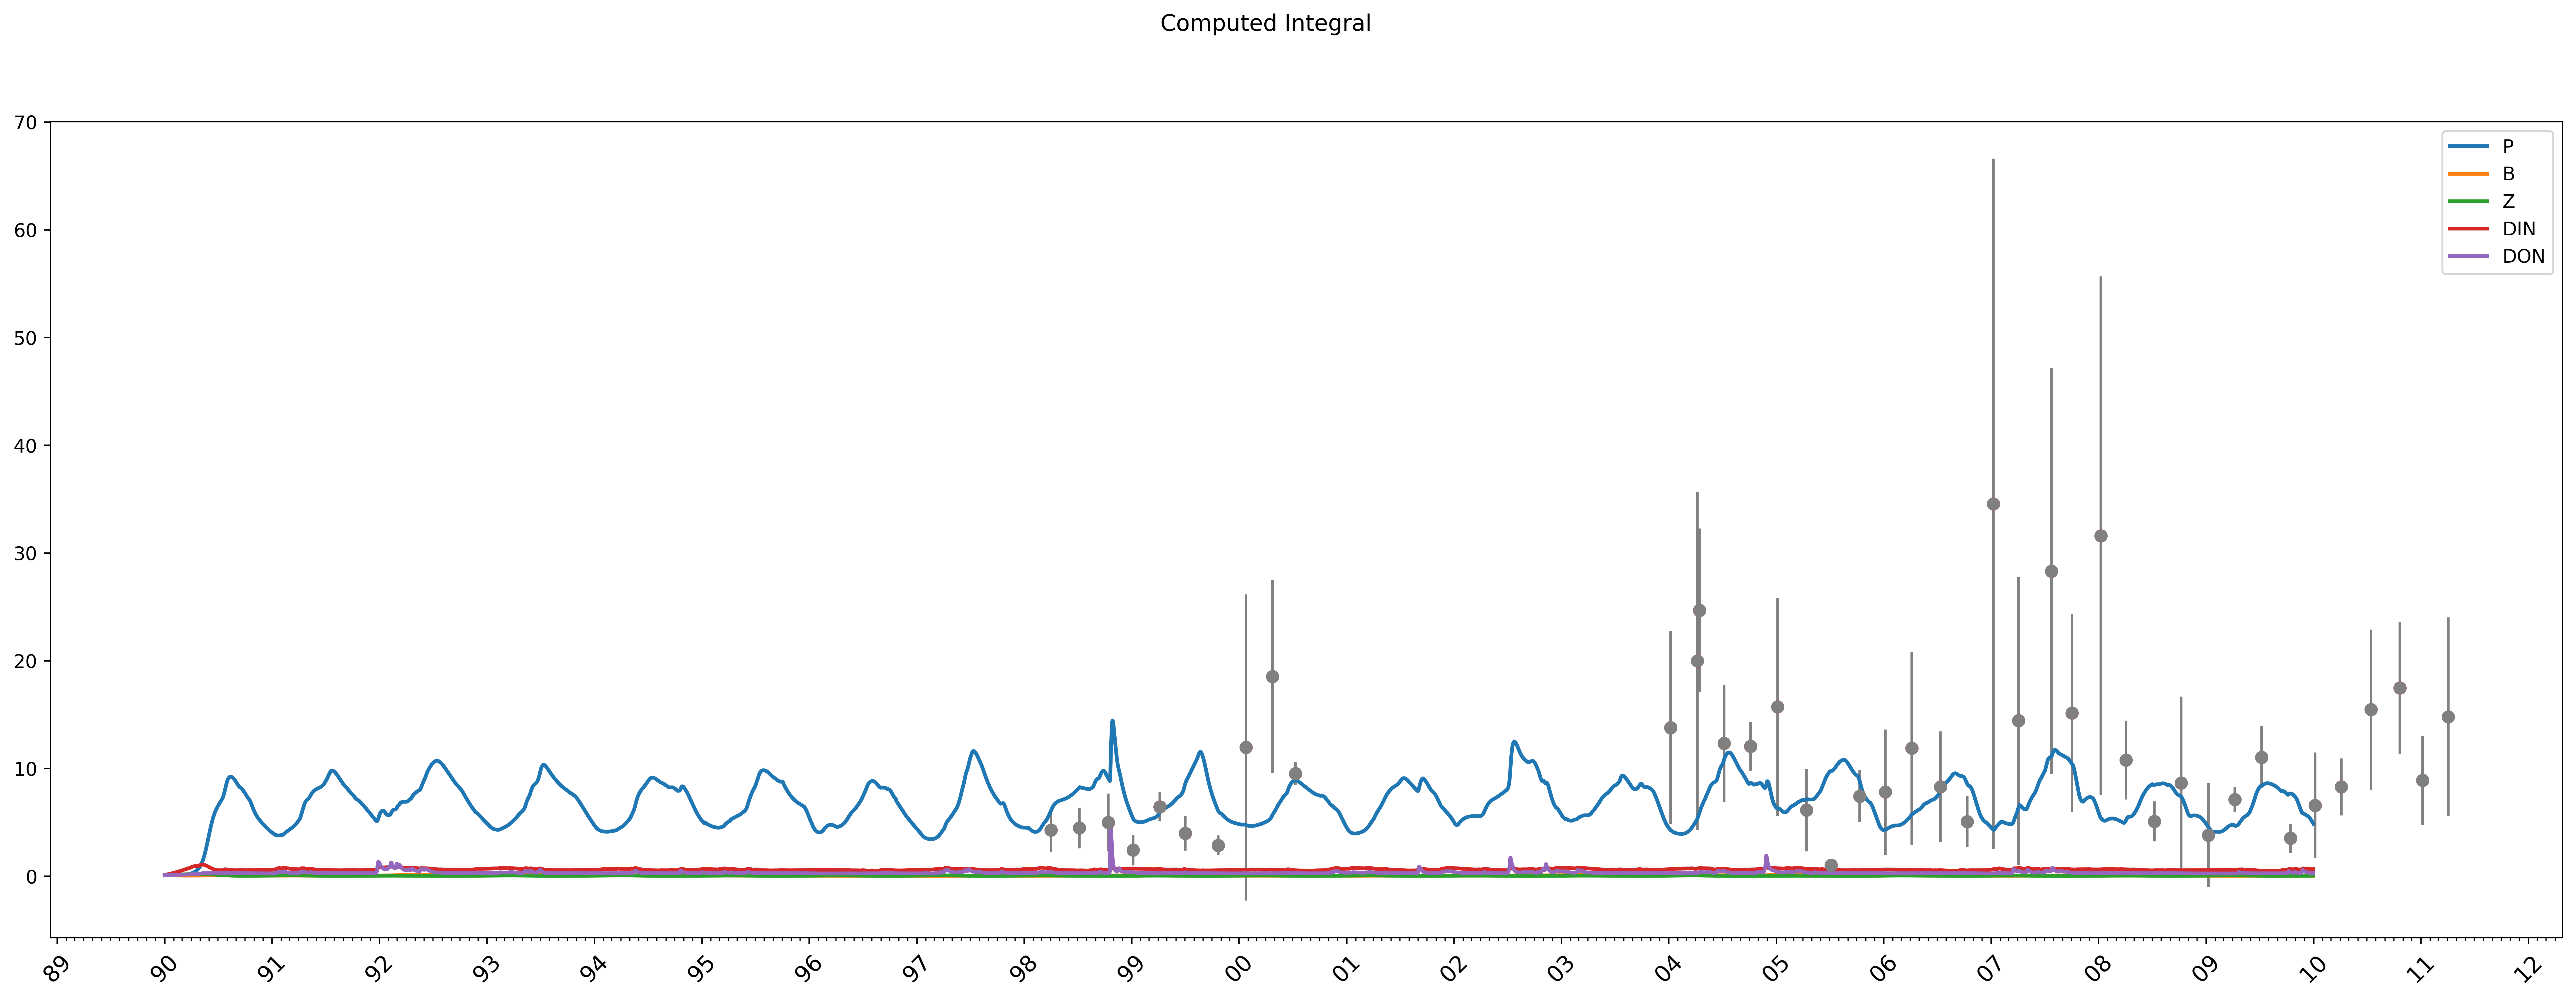

GFMODEL #35 Xtot:4.186 RMSD:45.0 RMSE:9.638 RANGE%54.3 MSER:15.9 WMSE:12.2
Label	Value	Min	Max	ISConst	Desc
i 	 0.80740323753 	 0.01 	 3.0 	 False 	 None
Pg 	 2.167839 	 0.01 	 3.0 	 False 	 None
Bg 	 1.18904 	 0.01 	 3.0 	 False 	 None
e 	 0.3656 	 0.01 	 2.0 	 False 	 None
Zm 	 0.812665611 	 0.01 	 3.0 	 False 	 None
Pm 	 0.509776 	 0.01 	 3.0 	 False 	 None
Bm 	 1.0108543 	 0.01 	 1.5 	 False 	 None
Pe 	 0.88884 	 0.01 	 3.0 	 False 	 None
Be 	 0.894376 	 0.01 	 1.5 	 False 	 None
Pr 	 1.6583455 	 0.01 	 3.0 	 False 	 None
h 	 0.3765959 	 0.01 	 3.0 	 False 	 None
s 	 2.130104872 	 0.01 	 3.0 	 False 	 None
f 	 0.110332211 	 0.01 	 2.0 	 False 	 None
in_scale 	 11.5 	 9.0 	 25.0 	 False 	 None


In [6]:
#validate to CHLA
NPZUS.Integrate(NPZUScalibration.initial, Calibration=best,TimeSeries= nutrients_UT, dt=0.01) 
NPZUS.Validate(chla_observation, graph =True, legend=legend) 
NPZUS.fit.Print()
best.Print()

Org. fitness: 7.107  Range%:  45.7
0 New. fitness MSE: 7.170999999999999  Range%:  44.3
1 New. fitness MSE: 10.123  Range%:  32.85
2 New. fitness MSE: 16.939  Range%:  17.15
3 New. fitness MSE: 12.687  Range%:  25.7
4 New. fitness MSE: 7.384  Range%:  47.1
5 New. fitness MSE: 7.484500000000001  Range%:  41.45
6 New. fitness MSE: 12.1615  Range%:  21.45
7 New. fitness MSE: 9.6175  Range%:  34.25
8 New. fitness MSE: 7.5435  Range%:  41.45
9 New. fitness MSE: 7.813000000000001  Range%:  35.7
10 New. fitness MSE: 7.616  Range%:  42.85
11 New. fitness MSE: 8.3785  Range%:  37.15
12 New. fitness MSE: 10.881499999999999  Range%:  28.55
13 New. fitness MSE: 10.929  Range%:  31.400000000000002
14 New. fitness MSE: 7.358499999999999  Range%:  47.15
15 New. fitness MSE: 7.22  Range%:  40.0
16 New. fitness MSE: 7.246  Range%:  47.15
17 New. fitness MSE: 8.1  Range%:  35.7
18 New. fitness MSE: 8.011  Range%:  37.15
19 New. fitness MSE: 8.0585  Range%:  38.55
20 New. fitness MSE: 8.6735  Range%:  34

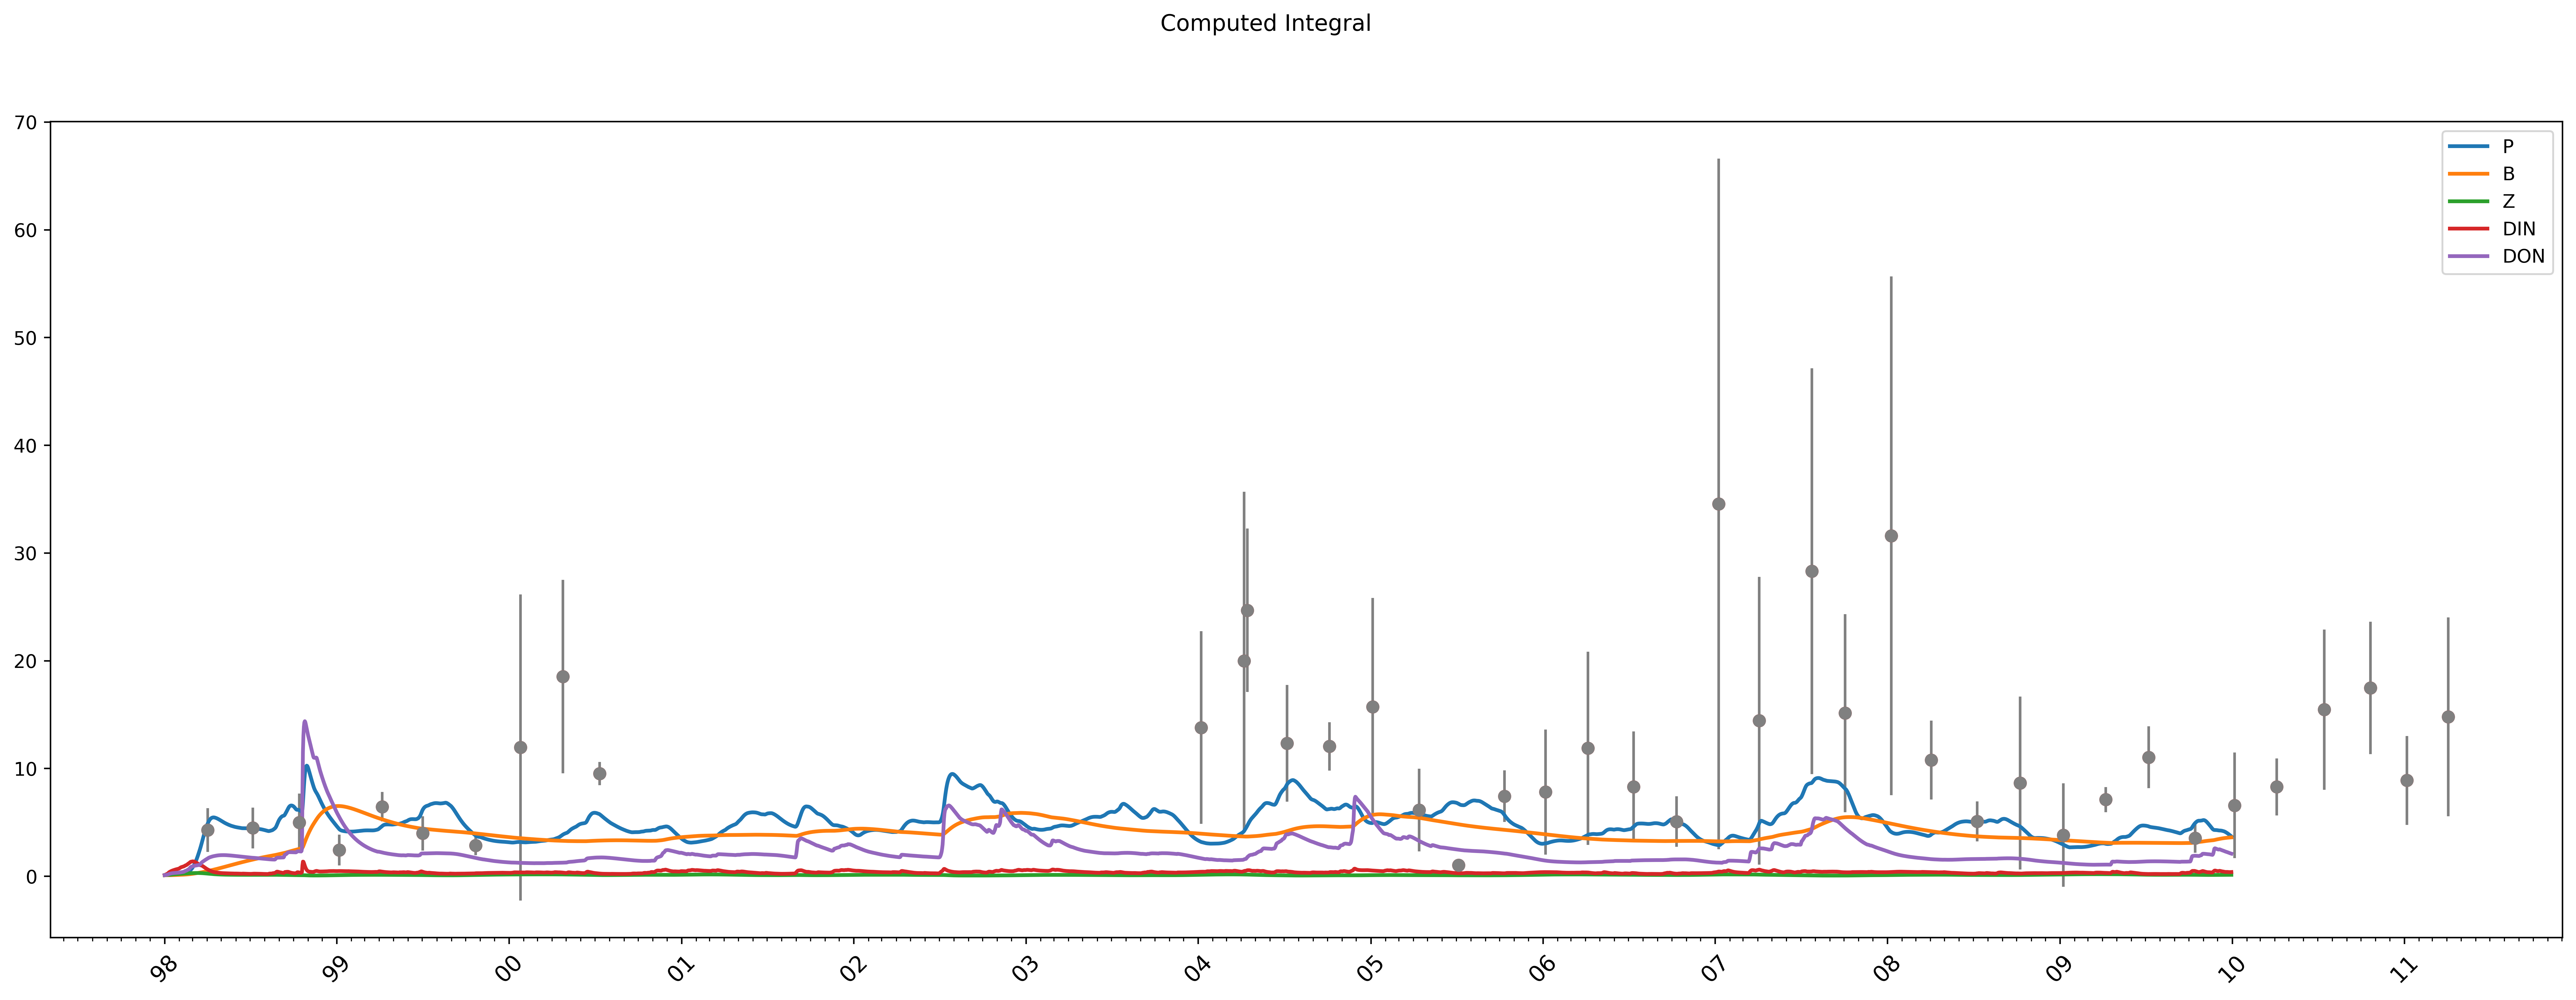

In [30]:
import copy
import datetime as dt

runs = 100
start = dt.datetime(1998,1,1).date()
end = dt.datetime(2009,12,31).date()


NPZUS.Integrate(NPZUScalibration.initial, Calibration=best,TimeSeries= nutrients_UT, start=start, end=end, dt=0.01) 
GF_benthos = NPZUS.Validate(benthos_observation)
#GF_zoop = NPZUS.Validate(zoop_observation)
GF_chla = NPZUS.Validate(chla_observation)
#avg_MSE = ( GF_benthos.MSE + GF_zoop.MSE + GF_chla.MSE)/ 3
#avg_RANGE = (GF_benthos.RANGE + GF_zoop.RANGE + GF_chla.RANGE) / 3
avg_RANGE = (GF_benthos.RANGE + GF_chla.RANGE) / 2
avg_MSE = (GF_benthos.MSE  + GF_chla.MSE) / 2 
#avg_RANGE = GF_chla.RANGE
#avg_MSE = GF_chla.MSE
    
best = None
print ("Org. fitness:", avg_MSE, " Range%: ", avg_RANGE)

for i in range(runs):
    testingC = copy.deepcopy(NPZUScalibration)
    testingC.Randomize()
    NPZUS.Integrate(NPZUScalibration.initial, Calibration=testingC,TimeSeries= nutrients_UT, start=start, end=end, dt=0.01) 
    GF_benthos_new = NPZUS.Validate(benthos_observation)
    GF_zoop_new = NPZUS.Validate(zoop_observation)
    GF_chla_new = NPZUS.Validate(chla_observation)
    #avgRANGE_new = (GF_benthos_new.RANGE + GF_zoop_new.RANGE + GF_chla_new.RANGE) / 3
    #avgMSE_new = (GF_benthos_new.MSE + GF_zoop_new.MSE + GF_chla_new.MSE) / 3
    avgRANGE_new = (GF_benthos_new.RANGE + GF_chla_new.RANGE) / 2
    avgMSE_new = (GF_benthos_new.MSE  + GF_chla_new.MSE) / 2
    #avgRANGE_new = (GF_chla_new.RANGE) 
    #avgMSE_new = (GF_chla_new.MSE) 
    print (i, "New. fitness MSE:", avgMSE_new, " Range%: ", avgRANGE_new)
    
    
    #if (GF_benthos_new.MSE  is 0) or (GF_zoop_new.MSE  is 0) or (GF_chla_new.MSE  is 0):
    #    print (i, "invalid...")
    #    #continue
    #if (GF_benthos_new.RANGE  is 0)  
    if (GF_chla_new.RANGE  is 0):  # zoop count it so small we cant strip by range =0
        print (i, "invalid...")
        continue
        
        
    if (avgRANGE_new >= avg_RANGE) and (avgMSE_new <= avg_MSE):
        #if (avgRANGE_new >= avg_RANGE):
        best = testingC
        print(i, "New Best Calibration:")
        best.Print()
        avg_RANGE = avgRANGE_new
        avg_MSE = avgMSE_new
    
NPZUS.Validate(chla_observation, graph =True, legend=legend)         
if best:  #if we found a best calibration lets print it out
    NPZUS.Integrate(NPZUScalibration.initial, Calibration=best,TimeSeries= nutrients_UT, dt=0.01)
    NPZUS.Validate(chla_observation, graph =True, legend=legend) 
    #NPZUS.Validate(benthos_observation, graph =True, legend=legend) 
    #NPZUS.Validate(zoop_observation, graph =True, legend=legend) 
    NPZUS.fit.Print()
    best.Print()
    

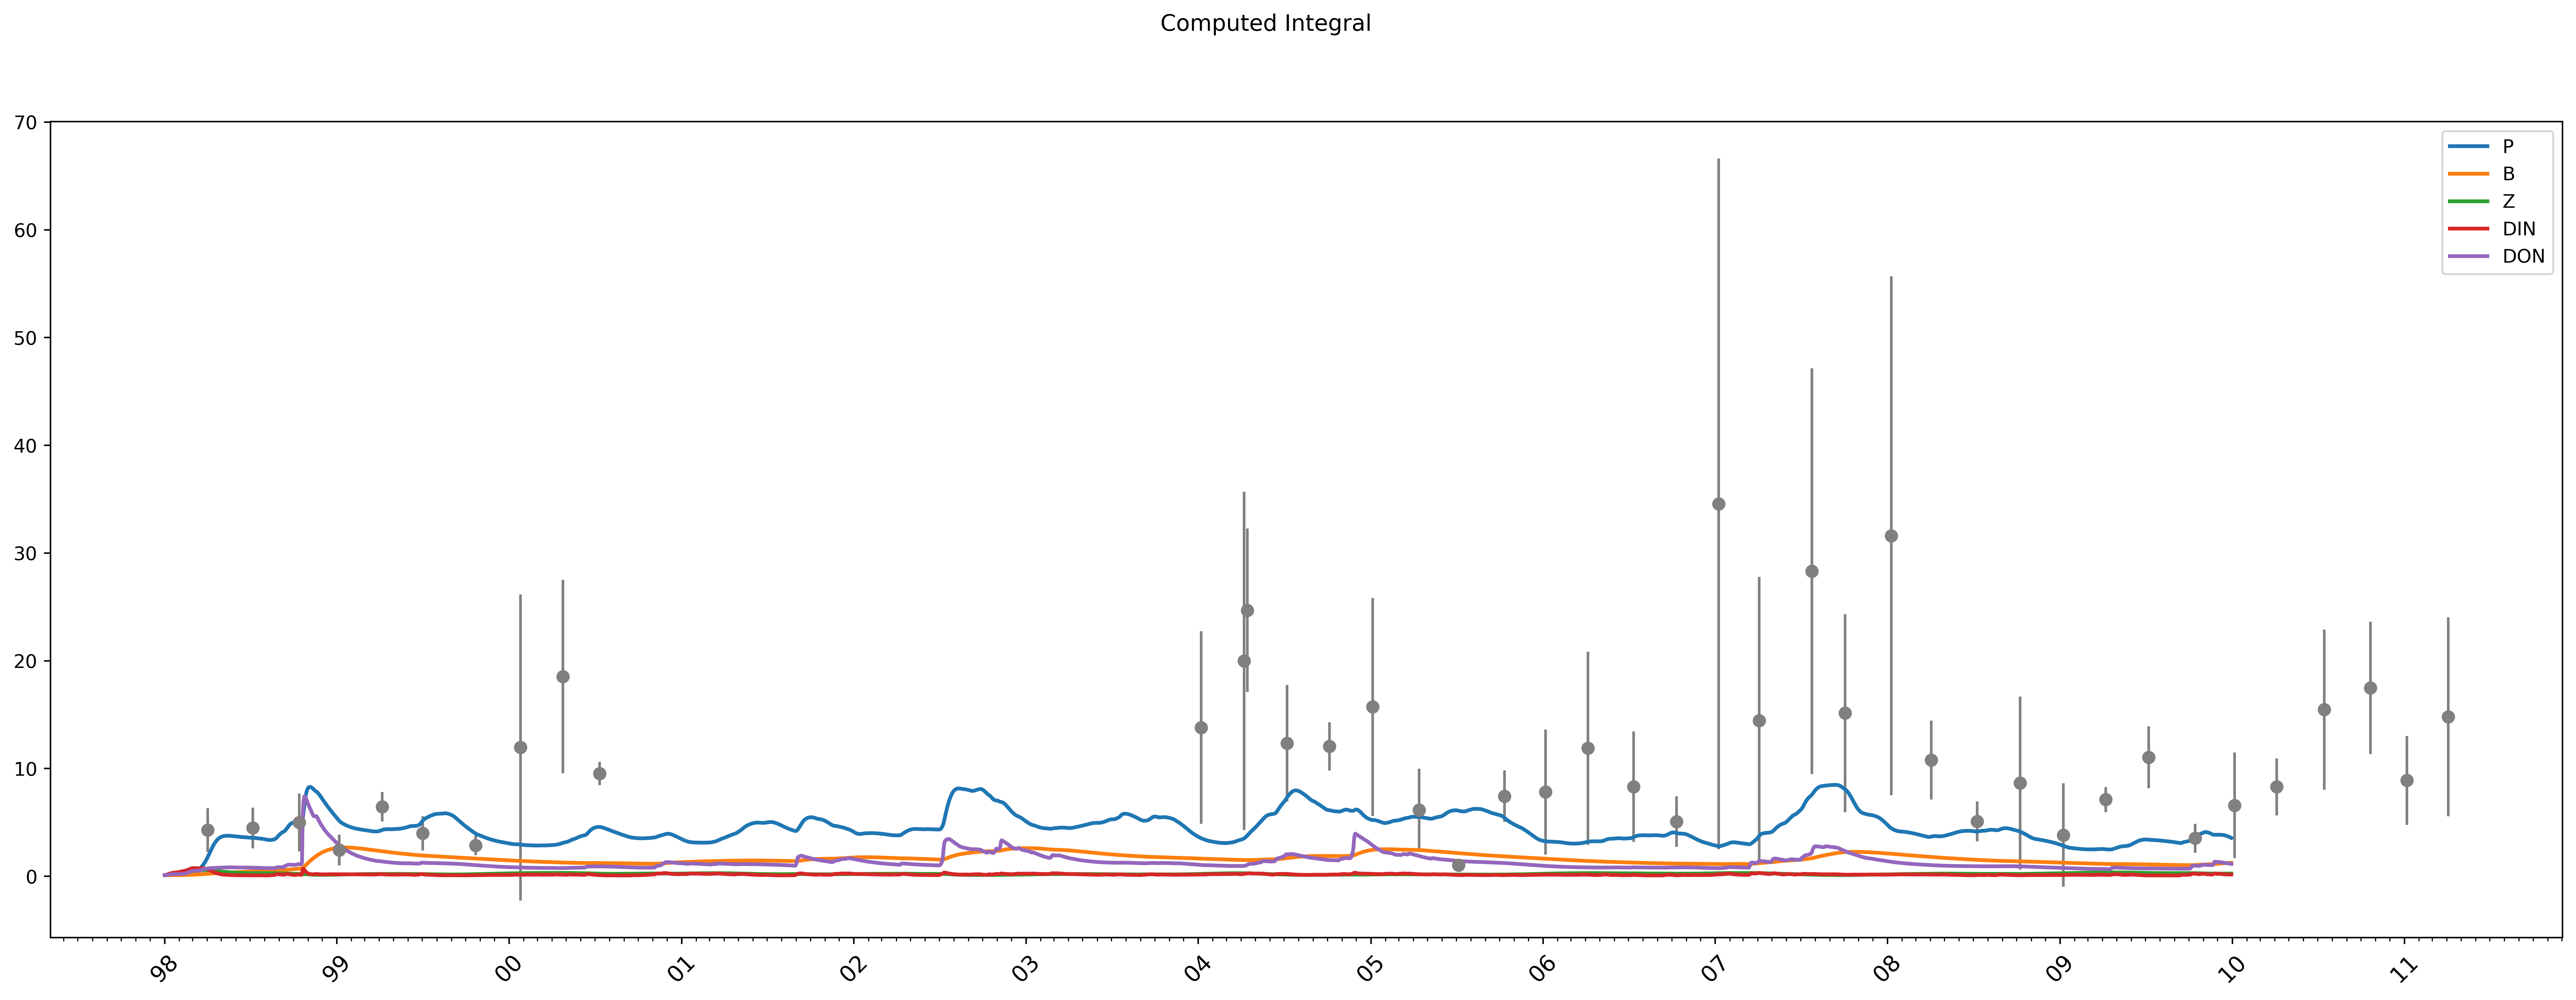

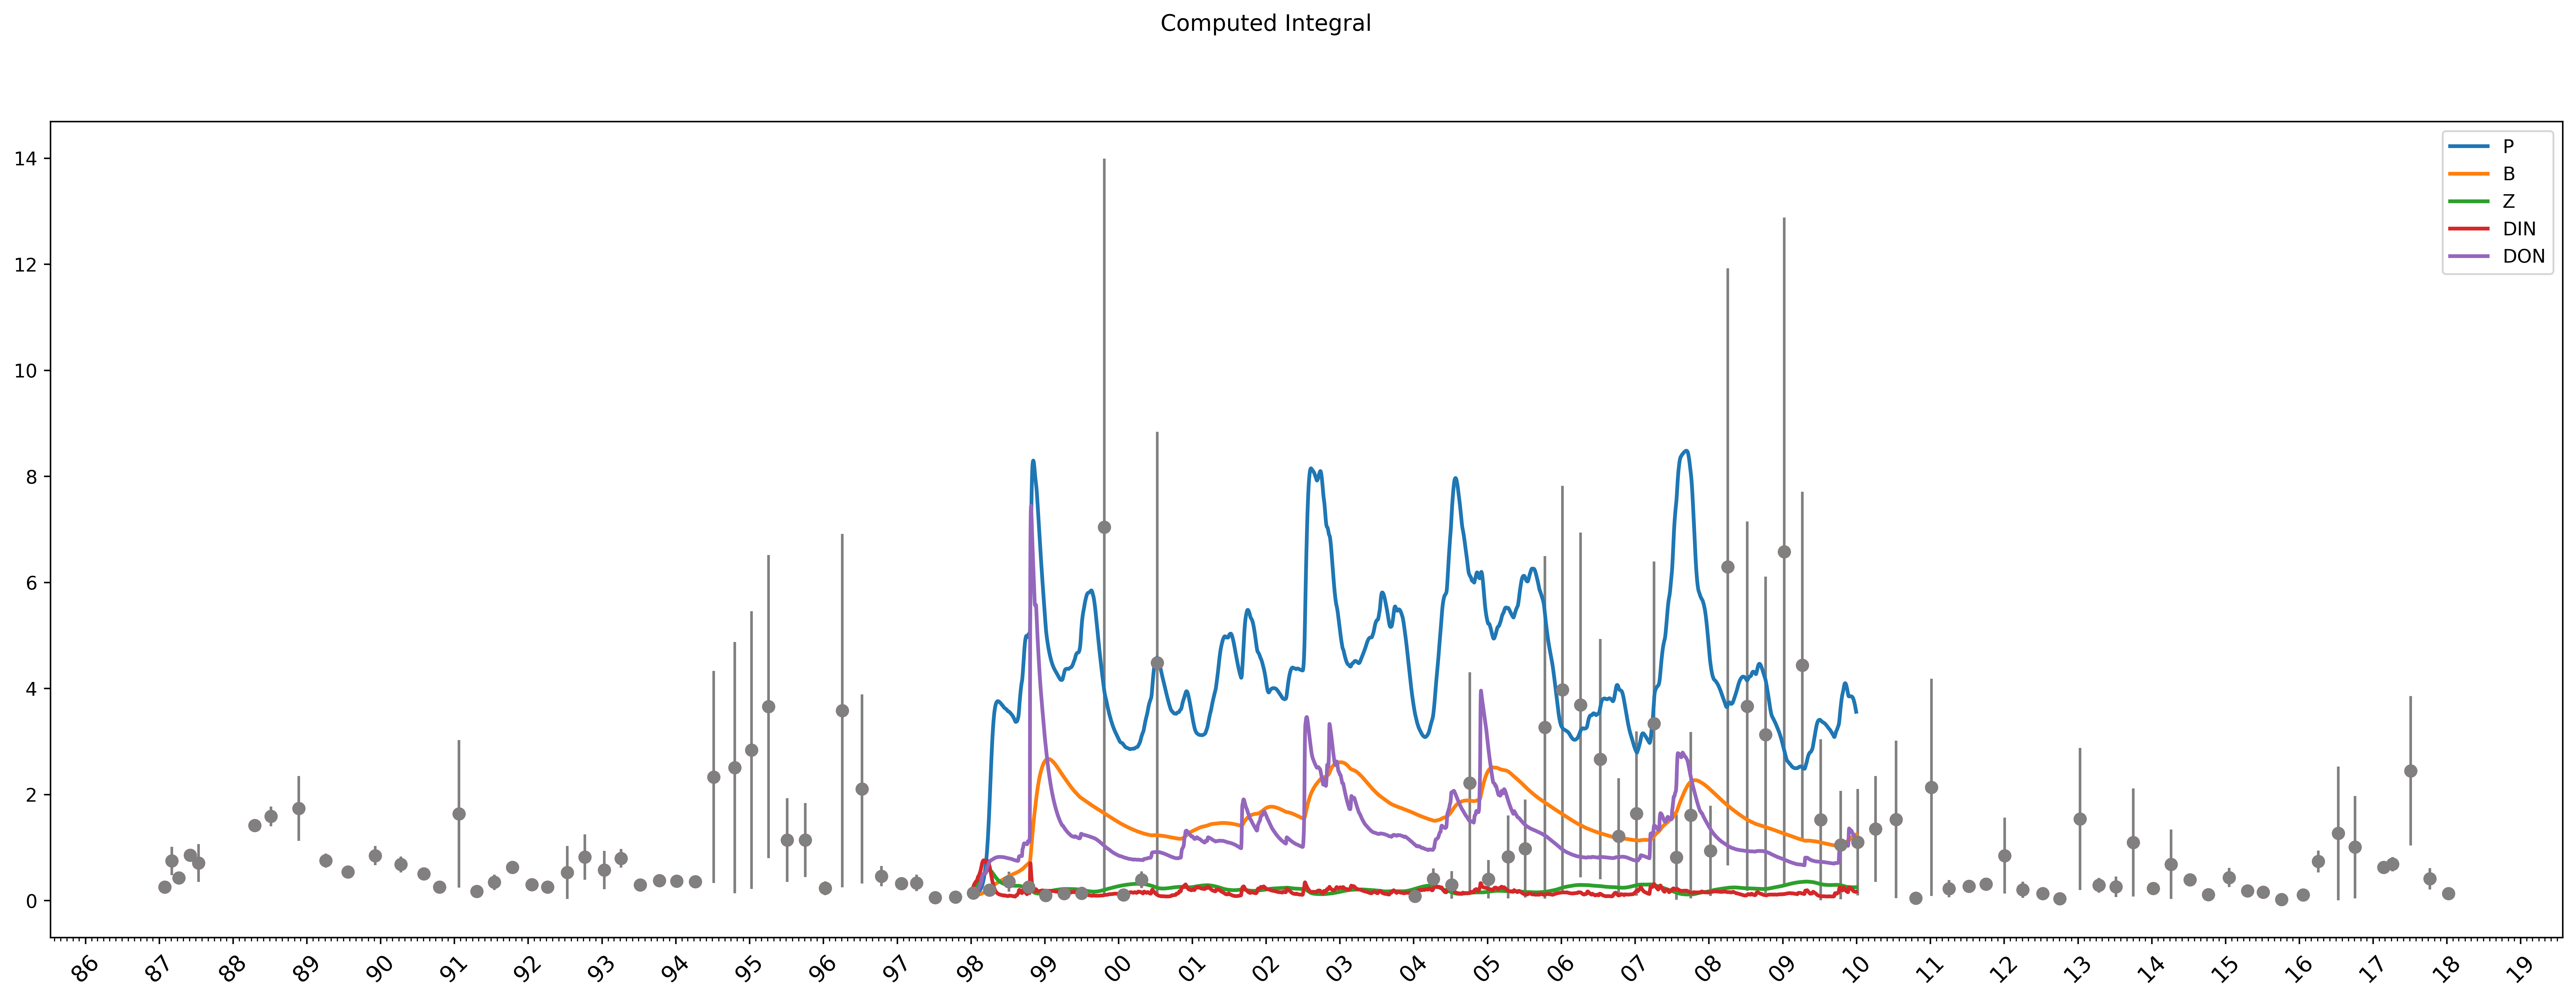

GFMODEL #35 Xtot:1.57 RMSD:0.0 RMSE:3.536 RANGE%40.0 MSER:17.6 WMSE:18.9


In [28]:
saved1 = best
NPZUS.Integrate(NPZUScalibration.initial, Calibration=saved1,TimeSeries= nutrients_UT,  start=start, end=end,dt=0.01)
NPZUS.Validate(chla_observation, graph =True, legend=legend) 
NPZUS.Validate(benthos_observation, graph =True, legend=legend) 
#NPZUS.Validate(zoop_observation, graph =True, legend=legend) 
NPZUS.fit.Print()
    

In [20]:
best.Print()

Label	Value	Min	Max	ISConst	Desc
Pg 	 2.4426248734270324 	 0.01 	 3.0 	 False 	 None
Bg 	 0.37945555769494094 	 0.01 	 3.0 	 False 	 None
e 	 0.39359173589792473 	 0.01 	 1.0 	 False 	 None
Zm 	 1.7465396801151745 	 0.01 	 3.0 	 False 	 None
Pm 	 0.7617763812099586 	 0.01 	 1.0 	 False 	 None
Bm 	 0.5838926465450298 	 0.01 	 1.0 	 False 	 None
Pe 	 0.6516293290701766 	 0.01 	 1.0 	 False 	 None
Be 	 0.5895186570717368 	 0.01 	 1.0 	 False 	 None
Pr 	 0.13763419060220836 	 0.01 	 1.0 	 False 	 None
h 	 0.3070330744928286 	 0.01 	 1.0 	 False 	 None
s 	 0.9945668725067918 	 0.01 	 1.0 	 False 	 None
f 	 0.014209348028953362 	 0.01 	 1.0 	 False 	 None
in_scale 	 11.216504067651668 	 9.0 	 25.0 	 False 	 None
